In [ ]:
# !python -m venv venv
# # !venv/scripts/activate
%pip install pandas numpy matplotlib seaborn plotly geopandas scipy scikit-learn statsmodels requests aiohttp shapely ipython h3 ipywidgets dtale tqdm pickle

In [199]:

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

import requests
import os

import datetime as dt

from pandas import read_csv
import concurrent.futures
import psutil

from datetime import datetime

import h3
import geopandas as gpd
import shapely
import plotly.express as px

from tqdm import tqdm
tqdm.pandas()

from pandas import read_pickle
import matplotlib.dates as mdates




In [ ]:
# Verify that the hexagon grid is suitable
# create_choropleth_map_only_hexagon_df(geojson_df=hexagon_df)

# def create_choropleth_map_only_hexagon_df(geojson_df, alpha=0.1, map_style="carto-positron", color_scale="Viridis"):
#     """
#     Create an interactive choropleth map using Plotly Express.
#     Parameters:
#     - geojson_df (GeoDataFrame): GeoJSON data containing polygon geometries.
#     - alpha (float): Opacity level for the map polygons (0.0 to 1.0).
#     - map_style (str): Map style for the Plotly map (e.g., "carto-positron").
#     - color_scale (str): Color scale for the choropleth map.
#     Returns:
#     None
#     """
#     # Create a choropleth map using px.choropleth_mapbox
#     fig = px.choropleth_mapbox(
#         geojson_df,
#         geojson=geojson_df.geometry,
#         locations=geojson_df.index,  # Use index as locations to avoid duplicate rows
#         # color="Count",
#         color_continuous_scale=color_scale,
#         title="GPS Jam Map",
#         mapbox_style=map_style,
#         center={"lat": home_lat, "lon": home_lng},  # Adjust the center as needed
#         zoom=2,
#     )

#     # Customize the opacity of the hexagons
#     fig.update_traces(marker=dict(opacity=alpha))

#     # Set margins to 25 on all sides
#     fig.update_layout(margin=dict(l=35, r=35, t=45, b=35))
    
#     # Adjust the width of the visualization
#     fig.update_layout(width=1000) 

#     fig.show()


Loading csv csv\joined\20240401joined.csv: 6it [00:08,  1.36s/it]
Loading csv csv\joined\20240401flights_data.csv: 1it [00:00, 117.64it/s]


result
normal               13203
analyse               1389
equipment_failure      224
Name: count, dtype: int64

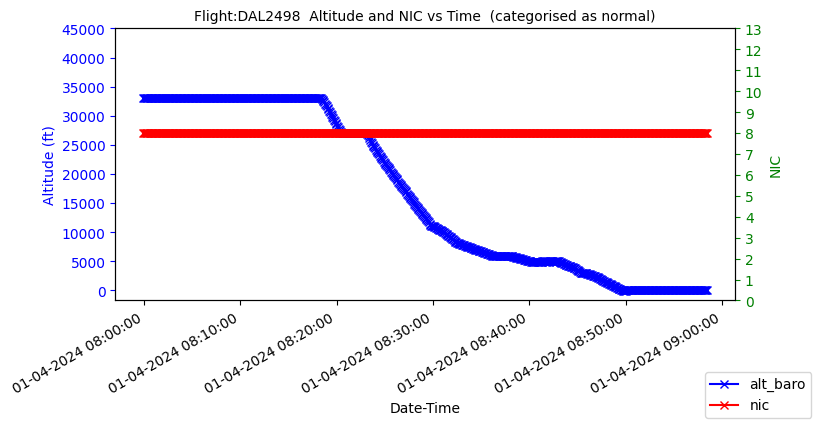

https://doc8643.com/aircraft/B739
https://doc8643.com/static/img/aircraft/large/B739.jpg


HTTPError: HTTP Error 403: Forbidden

In [200]:



# Latitude and longitude coordinates
home_lat = 1.3472764
home_lng = 103.9104234

# Generate H3 hexagons at a specified resolution (e.g., 9)
resolution = 5

# Indicate the number of rings around the central hexagon
ring_size = 463

# global dataframes to avoid keep loading files
df1=None
df2=None
flight_data=None

def calculate_hexagon_ids(df):
    """
    Calculate Hexagon IDs for each row(ping) in a DataFrame based on their geographic coordinates.
    Args:
        df (pd.DataFrame): DataFrame containing ADSB data with "lat" and "lon" columns.
        hexagon_df (gpd.GeoDataFrame): GeoDataFrame with hexagon geometries and associated Hexagon IDs.
    Returns:
        pd.DataFrame: The input DataFrame with an additional "Hexagon_ID" column indicating the Hexagon ID for each ping.
    """

    # Create a column Hexagon_ID with the ID of the hexagon
    df['Hexagon_ID'] = None

    # Iterate through the hotels in the df DataFrame and calculate hotel counts within each hexagon
    for i, ping in df.iterrows():
        if not isinstance(ping['lat'], float):
            # use location of last ping
            found = False
            j=1
            while not found:
                if isinstance(df.loc[i-j,'lat'],float):
                    df.loc[i,'lat']=df.loc[i-j,'lat']
                    df.loc[i,'lng']=df.loc[i-j,'lng']
                elif isinstance(df.loc[i+j,'lat'],float):
                    df.loc[i,'lat']=df.loc[i+j,'lat']
                    df.loc[i,'lng']=df.loc[i+j,'lng']
                else:
                    j+=1
            continue
        resolution=5   
        result = h3.geo_to_h3(ping["lat"], ping["lon"], resolution)
        # print(f'{ping["lat"]},{ping["lon"]}=>{result}')
        if result != 0:
             df.loc[i, 'Hexagon_ID'] = result
    
    return df

def get_adsb_data(data):
    try:
        response = requests.get(data["url"])
        print(f"downloaded {data['url']}")
        json_data = response.json()
        
        df = pd.json_normalize(json_data['aircraft'])

        df = df[df["type"] == 'adsb_icao']
        df['time'] = pd.to_datetime(datetime.fromtimestamp(json_data['now']).strftime("%Y%m%d%H%M%S"))
        df['Hexagon_ID'] = pd.NA
        df['good_bad'] = np.NaN
        df = df[['flight','r','time', 'hex', 'Hexagon_ID', 'alt_baro', 'nic', 'good_bad','lat','lon','type','t','category','version','nac_p','nac_v','track','baro_rate','seen_pos','seen','gs','alt_geom']]	
        df = df[df["type"] == 'adsb_icao']
        df['alt_baro'] = df['alt_baro'].apply(lambda x: 0 if (x == "ground" or x == np.nan ) else float(x))
        df["nic"] = df["nic"].replace(np.NaN,0)

        df = calculate_hexagon_ids(df)

        mapping = {
            "flight": str,
            "r": str,
            "time": "datetime64[ns]",
            "hex": str,
            "Hexagon_ID": str,
            "alt_baro": float,
            "nic": float,
            "good_bad": bool,
            "lat": float,
            "lon": float,
            "type": str,
            "t": str,
            "category": str,
            "version": float,
            "nac_p": float,
            "nac_v": float,
            "track": float,
            "baro_rate": float,
            "seen_pos": float,
            "seen": float,
            "gs": float,
            "alt_geom": float
        }
        df=df.astype(mapping, copy=True)
        df['good_bad'] = df['nic'].apply(lambda x: False if x==np.NaN or x<7 else True)
        df = df[~df["flight"].isnull()]

        #save to pickle
        if not os.path.exists(os.path.dirname(data["csv"])):
            os.makedirs(os.path.dirname(data["csv"]))
        df.to_csv(data["csv"])

    except Exception as e:
        # Handle other exceptions
        print("Get ADSB Data: An error occurred:", e)


def download_data(index, data, length_data_array):

    try:
        # if file exists, do nothing
        if (os.path.isfile(data["csv"])):
            print(f"csv exists {data['csv']}")
            return
        else:
            get_adsb_data(data)
            return

    except Exception as e:
        # Handle other exceptions
        print("Download data: An error occurred:", e)

def join_large_file(folder_path,start,end,file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
    isHeader = True
    with open(file_path, 'w') as outfile:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            file_datetime = datetime.strptime(file_path, 'csv\\%Y%m%d\\%H%M%SZ.csv')
            print(file_datetime)
            if filename.endswith('.csv') and start <= file_datetime and file_datetime <= end:
                with open(file_path, 'r') as infile:
                    # skip row header
                    if isHeader:
                        outfile.write(infile.read())
                        isHeader = False
                    else:
                        outfile.write(''.join(infile.readlines()[1:]))
                print(f'Joined {file_path}')

def sampling(start_date_time):

    df1 = load_df(start_date_time, filetype=FileType.JOINED, pickle=False)
    df1_good = df1[df1['good_bad']==True]
    df1_good = df1_good.sort_values(['flight','time'],ignore_index=True)
    df1_good = df1_good.apply(
        lambda x: x.sample(frac=0.20)
    )
    print("good samples")
    df1_bad = df1[df1['good_bad']==False]
    print("bad samples")

    df1_sampled = pd.concat([df1_bad,df1_good], ignore_index=True)
    print("concat")

    print("sorting")
    df1_sampled = df1_sampled.sort_values(["flight","time"], ascending=[True,True], ignore_index=True)
    save_df(df1_sampled, start_date_time, filetype=FileType.SAMPLED, pickle=True)
    save_df(df1_sampled, start_date_time, filetype=FileType.SAMPLED, pickle=False)

    return df1_sampled

def get_flight_data(start_date_time):
    global df1
    flights = df1["flight"].unique()
    flights = flights[1:]
    display(flights.shape[0])
    flights_data = pd.DataFrame(flights, columns=['flight']).progress_apply(lambda x: process_flights_data(x['flight']), axis=1)
    display(flights_data.head(10))
    save_df(flights_data, start_date_time, filetype=FileType.FLIGHTS_DATA, parquet=False)
    return flights_data

def analyse_data(percentage_bad):
    upper_limit=0.9
    lower_limit=0.1
    if percentage_bad>upper_limit:
        return "equipment_failure"
    elif percentage_bad<lower_limit:
        return "normal"
    elif percentage_bad>=lower_limit and percentage_bad<=upper_limit:
        return "analyse"
    else: 
        return "unknown"

def process_flights_data(flight):
    rows = df1[df1['flight']==flight]
    # print(f"{flight} - {len(rows)} pings")
    bad_count = rows[rows['good_bad'] == False].shape[0]
    total_count = rows.shape[0]
    percentage_bad = bad_count/total_count
    result = analyse_data(percentage_bad)
    return pd.Series({'flight': flight, 'bad_count': bad_count, 'total_count': total_count, 'percentage_bad': percentage_bad, 'result': result})

    

def process_data(start_date_time,end_date_time, reload=[False,False,False]):
    delta = dt.timedelta(seconds=5)
    start = start_date_time
    global df1
    global df2
    file_path = os.path.join('csv', 'joined', f'{start_date_time.strftime("%Y%m%d")}joined.parquet')
    hexbin_path = os.path.join('csv', 'hexbin', f'{start_date_time.strftime("%Y%m%d")}hexbin.csv')

    if not reload[0]:

        data_array = []
        while start < end_date_time:
            data_array.append({
                "url": f'https://samples.adsbexchange.com/readsb-hist/{start.strftime("%Y/%m/%d")}/{start.strftime("%H%M%S")}Z.json.gz',
                "pickle": os.path.join('csv',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.pkl'),
                "csv": os.path.join('csv',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.csv')
                })
            start += delta

        try:
            with concurrent.futures.ThreadPoolExecutor() as executor:
                l = [len(data_array)] * len(data_array)
                list(executor.map(lambda i: download_data(i, data_array[i], l[i]), range(len(data_array))))
        except Exception as e:
            print("Thread Pool: An error occurred:", e)
            
        join_large_file(os.path.join('csv',start_date_time.strftime("%Y%m%d")),start_date_time,end_date_time,file_path)
        # csv_to_parquet(start_date_time, filetype = FileType.JOINED)

    
    df1 = load_df(start_date_time, filetype=FileType.JOINED, parquet=False)
    
    flights_data = get_flight_data(start_date_time)

    # df1 = sampling(start_date_time) if not reload[1] else load_df(start_date_time, filetype=FileType.SAMPLED, pickle=False)

    df2 = groupby_hexagon_ID(df1, hexbin_path) if not reload[2] else load_df(start_date_time, filetype=FileType.HEXBIN, pickle=True)

    return [df1, df2]

def groupby_hexagon_ID(df1, start_date_time):
    df2 = df1.groupby(['Hexagon_ID', 'r'], as_index=False).agg(
                            good_count=('good_bad', lambda x: (x == 'good').sum()),
                            bad_count=('good_bad', lambda x: (x == 'bad').sum()),
                            alt_baro_range=('alt_baro', lambda x: (x.max() - x.min())),
                            time_range=('time', lambda x: x.max() - x.min()))

    df2["total_count"]=df2["good_count"]+df2["bad_count"]
    df2["percentage_bad"]=df2["bad_count"]/df2["total_count"]
    def get_lat(row):
        return h3.h3_to_geo(row['Hexagon_ID'])[0]

    def get_lng(row):
        return h3.h3_to_geo(row['Hexagon_ID'])[1]

    # Apply the function to create new 'lat' and 'lng' columns
    df2['lat'] = df2.apply(get_lat, axis=1)
    df2['lng'] = df2.apply(get_lng, axis=1)

    save_df(df2, start_date_time, filetype=FileType.HEXBIN, pickle=True)

    return df2

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
            total_size_mb = total_size / (1024 * 1024)
    return total_size_mb

def get_memory_usage():

    # Get the memory usage
    memory_usage = psutil.virtual_memory()

    # Print the memory usage
    report = f"""
        Total Memory: {memory_usage.total / (1024 ** 3):.2f} GB
        Available Memory: {memory_usage.available / (1024 ** 3):.2f} GB
        Used Memory: {memory_usage.used / (1024 ** 3):.2f} GB
        Memory Usage Percentage: {memory_usage.percent:.2f}%
    """
    return report


class FileType:
    JOINED = "joined"
    BAD = "bad"
    GOOD = "good"
    SAMPLED = "sampled"
    EQUIPMENT_FAILURE = "eqpt_failure"
    NORMAL = "normal"
    UNKNOWN = "unknown"
    HEXBIN = "hexbin"
    FLIGHTS = "flights"
    FLIGHTS_DATA = "flights_data"
    FLIGHTS_EQPT_FAILURE = "flights_eqpt_failure"
    FLIGHTS_UNKNOWN = "flights_unknown"
    FLIGHTS_NORMAL = "flights_normal"

def save_df(df, start_date_time, filetype=FileType.JOINED, parquet=False):
    directory = 'joined'
    if filetype == FileType.HEXBIN:
        directory = 'hexbin'
    if parquet:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.parquet')
        print(f'Saving parquet {file_path}')
        df.to_parquet(file_path) 
    else:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.csv')
        print(f'Saving csv {file_path}')
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df)
            df.to_csv(file_path) 
        else:
            df.to_csv(file_path) 

def load_df(start_date_time, filetype=FileType.JOINED, parquet=False):
    directory = 'joined'
    if filetype == FileType.HEXBIN:
        directory = 'hexbin'
    if parquet:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.parquet')
        print(f'Reading parquet {file_path}')
        return pd.read_parquet(file_path)
    else:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.csv')
        return pd.concat([chunk for chunk in tqdm(pd.read_csv(file_path, chunksize=1000000), desc=f'Loading csv {file_path}')])

def csv_to_parquet(start_date_time, filetype=FileType.JOINED):
    print("Converting csv to parquet")
    df1=load_df(start_date_time, filetype=filetype, parquet=False)
    save_df(df1, start_date_time, filetype=filetype, parquet=True)

def parquet_to_csv(start_date_time, filetype=FileType.JOINED):
    print("Converting parquet to csv")
    df1=load_df(start_date_time, filetype=filetype, parquet=True)
    save_df(df1, start_date_time, filetype=filetype, parquet=False)

class ResultGroup:
    EQUIPMENT_FAILURE = "equipment_failure"
    NORMAL = "normal"
    ANALYSE = "analyse"
    UNKNOWN = "unknown"

def generate_plots(sample_size, group = ResultGroup.ANALYSE):
    global df1
    global flights_data

    if isinstance(df1, type(None)) or isinstance(flights_data, type(None)):
        print("Generate plots: error no data")
        return

    flights = [str(flight) for flight in flights_data[flights_data['result']==group].sample(sample_size)['flight']]
    for flight in flights:
        flight_df = df1[df1['flight']==flight]
        flight_df.set_index("time")

        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(flight_df['time'].astype("datetime64[ns]"), flight_df['alt_baro'], 'bx-', label='alt_baro')
        ax1.tick_params('y', colors='b')
        ax1.set_yticks(np.arange(0, 50000, 5000))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))

        ax1.set_xlabel('Date-Time', fontsize=10)
        ax1.set_ylabel('Altitude (ft)', color='b', fontsize=10)

        plt.gcf().autofmt_xdate()

        ax2 = ax1.twinx()
        ax2.plot(flight_df['time'].astype("datetime64[ns]"), flight_df['nic'], 'rx-', label='nic')
        ax2.set_ylabel('NIC', color='g', fontsize=10)
        ax2.tick_params('y', colors='g')
        ax2.set_yticks(np.arange(0, 14, 1))

        plt.title(f'Flight:{flight} Altitude and NIC vs Time  (categorised as {group})', fontsize=10)
        fig.legend(loc="lower right")
        plt.show()
        url = f"https://doc8643.com/aircraft/{flight_df.iloc[0]['t']}"
        print(url)


# note that for the free sample, only the first day of each month is available on the adsbexchange
# 4 hours + to download 1 day of files
# 18 mins to reload

# Reload flags are for skipping steps and saving processing time
# reload[0] - 'False' downloads csv files if not exist and then joins the csv files into {date}joined.csv
#           - 'True' just uses the existing {date}joined.csv file
# reload[1] - 'False' samples the bad and good rows from {date}joined.csv file and saves as {date}sampled.csv
#           - 'True' just uses the existing {date}sampled.csv file
# reload[2] - 'False' runs grouby aggregate and sorts by Hexagon ID and saves as {date}hexbin.csv file
#           - 'True' just uses the existing {date}hexbin.csv file

# [df1,df2] = process_data(dt.datetime(2024,4,1,0,0,0),dt.datetime(2024,4,1,1,1,0), reload=[False, False, False])

start_date_time = dt.datetime(2024,4,1,0,0,0)
df1 = load_df(start_date_time, filetype=FileType.JOINED, parquet=False)
flights = df1["flight"].unique()
flights = flights[1:]
# display(flights.shape[0])
# flights_data = pd.DataFrame(flights, columns=['flight']).progress_apply(lambda x: process_flights_data(x['flight']), axis=1)
flights_data = load_df(start_date_time, filetype=FileType.FLIGHTS_DATA, parquet=False)
display(flights_data['result'].value_counts())

generate_plots(5, group=ResultGroup.NORMAL)
# generate_plots(5, group=ResultGroup.ANALYSE)
# generate_plots(5, group=ResultGroup.EQUIPMENT_FAILURE)

In [ ]:
# DO
# 1. .info() to get data types  or .dtypes  
# 2. .describe() 0> gets mean() count(), 25%, 50%, 75% max min
# 3. .isnull() check for missing values   ->  isnull().sum().sort_values(ascending=False)
# 4. .nunique() -> gets unique values for each field with their counts
# 5. .unique() -> gets a list of unique values in a column
# 6. .value_counts() -> gets unique values for the column with their counts
# 7. for name, group in grouped: -> iterate over groups
# 8. pandas time series functions: Timestamp->DatetimeIndex[] (to_datetime, date_range), Timedelta->TimedeltaIndex[] (to_timedelta, timedelta_range), Period->PeriodIndex[] (Period, period_range), DateOffset (Dateoffset)
# 9. Missing Values: Numeric (pd.nan), String (pd.NA), Time (pd.NaT) -> use .isna(), .notna() to detect missing values

# DON'T DO
# 1. seems like saving as a pickle may corrupt the data, I see a lot of NA, maybe due to the data conversion between types. avoid any data conversion except at the start
# 2. use display() instead of print() 
# 3. .dropna() -> WRONG USE, drops any row or column with a missing value!
# 4. df[df[]] is a filter, not selecting the rows. it is wrong

# flights time Hexagon_ID good_bad lat lon
# problem: some lat lon are NaN because of GPS failure. To assign nearest hexagon_ID based on nearest time with lat lon


# url = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000000Z.json.gz'
# response = requests.get(url)
# json_data = response.json()
# df1 = pd.json_normalize(json_data['aircraft'])



def analyse_data(percentage_bad):
    upper_limit=0.9
    lower_limit=0.1
    if percentage_bad>upper_limit:
        return "equipment_failure"
    elif percentage_bad<lower_limit:
        return "normal"
    elif percentage_bad>=lower_limit and percentage_bad<=upper_limit:
        return "analyse"
    else: 
        return "unknown"

def process_flight_data(flight):
    rows = df1[df1['flight']==flight]
    # print(f"{flight} - {len(rows)} pings")
    bad_count = rows[rows['good_bad'] == False].shape[0]
    total_count = rows.shape[0]
    percentage_bad = bad_count/total_count
    result = analyse_data(percentage_bad)
    return pd.Series({'flight': flight, 'bad_count': bad_count, 'total_count': total_count, 'percentage_bad': percentage_bad, 'result': result})

start_date_time = dt.datetime(2024,4,1,0,0,0)
df1 = load_df(start_date_time, filetype=FileType.JOINED, parquet=False)
flights = df1["flight"].unique()
flights = flights[1:]
display(flights.shape[0])
flights_data = pd.DataFrame(flights, columns=['flight']).progress_apply(lambda x: process_flight_data(x['flight']), axis=1)

display(flights_data.head(10))

save_df(flights_data, start_date_time, filetype=FileType.FLIGHTS_DATA, parquet=False)

In [122]:
save_df(flights_data, start_date_time, filetype=FileType.FLIGHTS_DATA, parquet=False)

Saving csv csv\joined\20240401flights_data.csv


In [124]:
save_df(flights, start_date_time, filetype=FileType.FLIGHTS, parquet=False)


Saving csv csv\joined\20240401flights.csv


N440QS  
24


,Unnamed: 0,flight,r,time,hex,Hexagon_ID,alt_baro,nic,good_bad,lat,lon,type,t,category,version,nac_p,nac_v,track,baro_rate,seen_pos,seen,gs,alt_geom
764059,8426,N440QS,N440QS,2024-04-01 08:07:39,a54c0c,8531853bfffffff,18900.0,8.0,True,39.948291,115.835974,adsb_icao,GLF4,A2,0.0,8.0,2.0,238.01,1984.0,0.978,1.0,336.0,19250.0
772213,8434,N440QS,N440QS,2024-04-01 08:07:44,a54c0c,8531853bfffffff,18900.0,8.0,True,39.948291,115.835974,adsb_icao,GLF4,A2,0.0,9.0,2.0,238.19,2112.0,5.978,0.6,337.7,19250.0
780363,8437,N440QS,N440QS,2024-04-01 08:07:49,a54c0c,8531853bfffffff,19150.0,8.0,True,39.942169,115.823242,adsb_icao,GLF4,A2,0.0,8.0,2.0,238.05,2048.0,3.581,3.6,338.2,19500.0
788517,8445,N440QS,N440QS,2024-04-01 08:07:54,a54c0c,8531853bfffffff,19425.0,8.0,True,39.935532,115.809387,adsb_icao,GLF4,A2,0.0,8.0,2.0,238.05,2048.0,0.611,0.6,338.2,19775.0
796657,8457,N440QS,N440QS,2024-04-01 08:07:59,a54c0c,8531853bfffffff,19425.0,8.0,True,39.935532,115.809387,adsb_icao,GLF4,A2,0.0,8.0,2.0,238.07,1920.0,5.611,4.4,344.1,19800.0
804781,8430,N440QS,N440QS,2024-04-01 08:08:04,a54c0c,8531853bfffffff,19425.0,8.0,True,39.935532,115.809387,adsb_icao,GLF4,A2,2.0,9.0,2.0,238.12,768.0,10.611,0.2,352.1,19800.0
812913,8423,N440QS,N440QS,2024-04-01 08:08:09,a54c0c,8531853bfffffff,19425.0,8.0,True,39.935532,115.809387,adsb_icao,GLF4,A2,2.0,9.0,2.0,238.06,704.0,15.611,4.3,353.5,19800.0
821031,8419,N440QS,N440QS,2024-04-01 08:08:14,a54c0c,85318577fffffff,19850.0,8.0,True,39.918172,115.773071,adsb_icao,GLF4,A2,2.0,9.0,2.0,238.08,1920.0,0.328,0.3,359.3,20225.0
829138,8420,N440QS,N440QS,2024-04-01 08:08:19,a54c0c,85318577fffffff,19850.0,8.0,True,39.918172,115.773071,adsb_icao,GLF4,A2,2.0,9.0,2.0,238.08,1920.0,5.328,5.3,359.3,20225.0
837253,8419,N440QS,N440QS,2024-04-01 08:08:24,a54c0c,85318577fffffff,19850.0,8.0,True,39.918172,115.773071,adsb_icao,GLF4,A2,2.0,9.0,2.0,238.08,1920.0,10.328,10.3,359.3,20225.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[Text(0, 0, '2024-04-01 08:07:39'), Text(1, 0, '2024-04-01 08:07:44'), Text(2, 0, '2024-04-01 08:07:49'), Text(3, 0, '2024-04-01 08:07:54'), Text(4, 0, '2024-04-01 08:07:59'), Text(5, 0, '2024-04-01 08:08:04'), Text(6, 0, '2024-04-01 08:08:09'), Text(7, 0, '2024-04-01 08:08:14'), Text(8, 0, '2024-04-01 08:08:19'), Text(9, 0, '2024-04-01 08:08:24'), Text(10, 0, '2024-04-01 08:08:29'), Text(11, 0, '2024-04-01 08:08:34'), Text(12, 0, '2024-04-01 08:08:39'), Text(13, 0, '2024-04-01 08:08:44'), Text(14, 0, '2024-04-01 08:08:49'), Text(15, 0, '2024-04-01 08:08:54'), Text(16, 0, '2024-04-01 08:08:59'), Text(17, 0, '2024-04-01 08:09:04'), Text(18, 0, '2024-04-01 08:09:09'), Text(19, 0, '2024-04-01 08:09:14'), Text(20, 0, '2024-04-01 08:09:19'), Text(21, 0, '2024-04-01 08:09:24'), Text(22, 0, '2024-04-01 08:09:29'), Text(23, 0, '2024-04-01 08:09:34')]


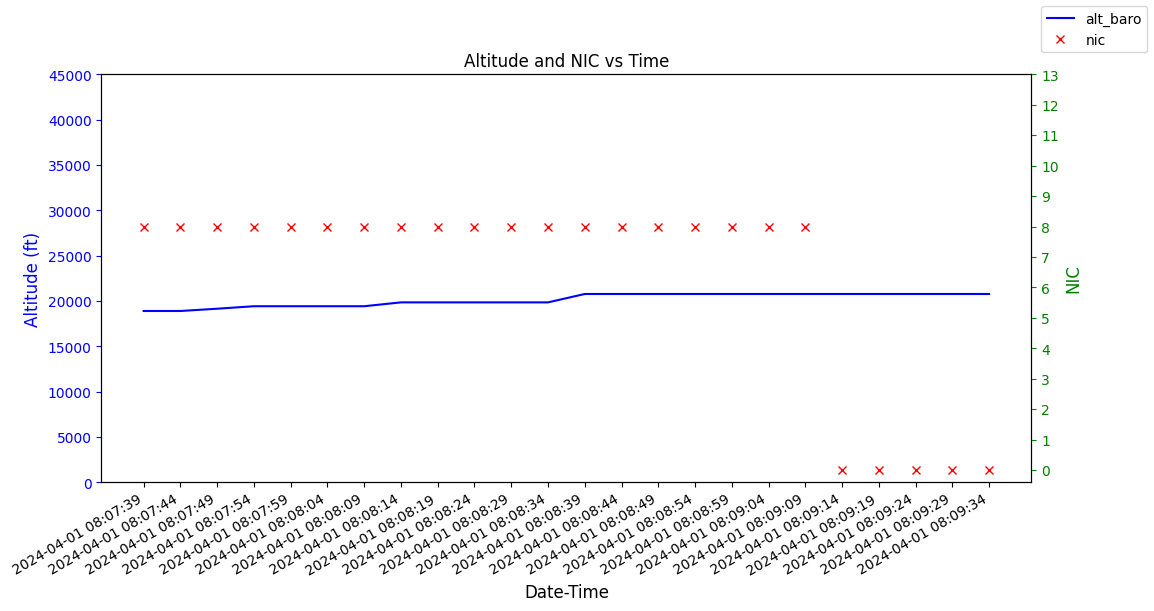

In [163]:
flight = str(flights_data[flights_data['result']=='analyse'].sample(1).iloc[0]['flight'])
print(flight)

flight_df = df1[df1['flight']==flight]
print(flight_df.shape[0])
display(flight_df.head(10))
flight_df.set_index("time")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(flight_df['time'], flight_df['alt_baro'], 'b-', label='alt_baro')
ax1.tick_params('y', colors='b')
ax1.set_yticks(np.arange(0, 50000, 5000))

ax1.set_xlabel('Date-Time', fontsize=12)
ax1.set_ylabel('Altitude (ft)', color='b', fontsize=12)

plt.gcf().autofmt_xdate()
locs, labels= plt.xticks()
print(locs)
print(labels)

ax2 = ax1.twinx()
ax2.plot(flight_df['time'], flight_df['nic'], 'rx', label='nic')
ax2.set_ylabel('NIC', color='g', fontsize=12)
ax2.tick_params('y', colors='g')
ax2.set_yticks(np.arange(0, 14, 1))

plt.title('Altitude and NIC vs Time')
fig.legend(loc="upper right")
plt.show()

In [ ]:
# sampling 
start_date_time = dt.datetime(2024,4,1,0,0,0)
df1 = load_df(start_date_time, filetype=FileType.JOINED, pickle=False)
print(df1.shape[0])
df1.head(300)

In [ ]:
# joined
start_date_time = dt.datetime(2024,4,1,0,0,0)
df2 = load_df(start_date_time, filetype=FileType.JOINED, pickle=False)
df2.head(50)

In [ ]:
df1_sampled = sampling(start_date_time)
# df1_sampled.head(50)
# df1_sampled.value_counts('r', dropna=False)


In [ ]:
print(df1_sampled.shape[0])
print(df1_sampled['flight'].dropna().shape[0])

In [ ]:
df1_sampled.head(50)

In [ ]:
start_date_time = dt.datetime(2024,6,1,0,0,0)
csv_to_pickle(start_date_time, filetype=FileType.JOINED)


In [ ]:
start_date_time = dt.datetime(2024,6,1,0,0,0)
df1=load_df(start_date_time, filetype=FileType.JOINED, pickle=True)
save_df(df1,start_date_time, filetype=FileType.SAMPLED, pickle=True)

In [ ]:
df1.head(10)

In [ ]:
df1=df1[:1000000]

In [ ]:
# flight_rows = None
# flights = None
# df1_groupby_r = df1.groupby("r")
# for r, rows in df1_groupby_r:
#     flight_rows = pd.concat([flight_rows, rows])
#     flights = pd.concat([flights,pd.DataFrame({'flight': [r],'row_count': [len(rows)], 'bad_count': [rows[rows['nic']<7].shape[0]]})])
#     print(r)
#     # rows['consecutive']
# flights.drop(0)
# flights.set_index('flight', inplace=True)
# flights['consecutive']=0
# for r, rows in df1_groupby_r:
#     print(r)
#     counter = 0
#     max_counter=0
#     if flights.at[r,'bad_count']>0:
#         for index, row in rows.iterrows():
#             if row['nic']<7:
#                 counter+=1
#                 if counter>max_counter:
#                     max_counter=counter
#             else:
#                 counter=0
#         flights.at[r,'consecutive']=max_counter
#     flights.at[r,'percentage_bad']=flights.at[r,'bad_count']/flights.at[r,'row_count']

#     if flights.at[r,'consecutive']>0.5*flights.at[r,'row_count'] or flights.at[r,'bad_count']>0.5*flights.at[r,'row_count']:
#         flights.at[r,'result']='equipment failure'
#     elif flights.at[r,'bad_count']<0.1*flights.at[r,'row_count']:
#         flights.at[r,'result']='normal'
#     else:
#         flights.at[r,'result']='unknown'

# flights = flights.sort_values('consecutive', ascending=False)
# print(flights.head(10))

flight_rows = pd.DataFrame()
flights = pd.DataFrame(columns=['flight', 'row_count', 'bad_count', 'consecutive', 'percentage_bad','result'])

def getResult(row_count, bad_count, max_consecutive):
    if max_consecutive > 0.5 * row_count or bad_count > 0.5 * row_count:
        return 'equipment failure'
    elif bad_count < 0.1 * row_count:
        return 'normal'
    else:
        return 'unknown'

for r, rows in df1.groupby("r"):
    flight_rows = pd.concat([flight_rows, rows])
    row_count = len(rows)
    bad_count = (rows['nic'] < 7).sum()
    percentage_bad = bad_count/row_count
    consecutive_counts = pd.Series([0]) if bad_count==0 else (rows['nic'] < 7).groupby((rows['nic'] < 7).cumsum()).cumcount() + 1
    max_consecutive = consecutive_counts.max()
    result = getResult(row_count, bad_count, max_consecutive)
    
    flights = pd.concat([flights, pd.DataFrame({'flight': [r], 'row_count': [row_count], 'bad_count': [bad_count], 'consecutive': [max_consecutive], 'percentage_bad': [percentage_bad], 'result':[result]})])
    
    
flights.set_index('flight', inplace=True)
flights = flights.sort_values('consecutive', ascending=False)

save_df(flights, start_date_time, filetype=FileType.FLIGHTS, pickle=True)
save_df(flight_rows, start_date_time, filetype=FileType.FLIGHT_ROWS, pickle=True)
save_df(flights.head(int(flights.shape[0]*0.01)), start_date_time, filetype=FileType.FLIGHTS, pickle=False)
save_df(flight_rows.head(int(flight_rows.shape[0]*0.01)), start_date_time, filetype=FileType.FLIGHT_ROWS, pickle=False)

In [ ]:
flights = load_df(start_date_time, filetype=FileType.FLIGHTS, pickle=True)

In [ ]:
flights_equipment_failure = flights[flights['result']=='equipment failure']
print(flights_equipment_failure.shape[0])

save_df(flights_equipment_failure, start_date_time, filetype=FileType.FLIGHTS_EQPT_FAILURE, pickle=True)
save_df(flights_equipment_failure.head(int(flights_equipment_failure.shape[0]*0.01)), start_date_time, filetype=FileType.FLIGHTS_EQPT_FAILURE, pickle=False)

flights_normal = flights[flights['result']=='normal']
print(flights_normal.shape[0])

save_df(flights_normal, start_date_time, filetype=FileType.FLIGHTS_NORMAL, pickle=True)
save_df(flights_normal.head(int(flights_normal.shape[0]*0.01)), start_date_time, filetype=FileType.FLIGHTS_NORMAL, pickle=False)

flights_unknown = flights[flights['result']=='unknown']
print(flights_unknown.shape[0])
print(flights_unknown.sample(50))

save_df(flights_unknown, start_date_time, filetype=FileType.FLIGHTS_UNKNOWN, pickle=True)
save_df(flights_unknown.head(int(flights_unknown.shape[0]*0.01)), start_date_time, filetype=FileType.FLIGHTS_UNKNOWN, pickle=False)



In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.hist(flights_unknown['percentage_bad'], bins=10, edgecolor='black', cumulative=False, density=True, color=color)
ax1.set_xlabel('Percentage Bad')
ax1.set_ylabel('Frequency', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
flights_unknown['percentage_bad'].plot(kind='hist', bins=10, cumulative=True, density=False, color=color, ax=ax2)
ax2.set_ylabel('Cumulative Percentage', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Distribution of percentage_bad with Cumulative Percentage')
fig.tight_layout()
plt.show()

In [ ]:

# https://towardsdatascience.com/3-python-packages-for-interactive-data-analysis-3063a201a589
# https://towardsdatascience.com/4-libraries-that-can-perform-eda-in-one-line-of-python-code-b13938a06ae


In [ ]:

# hexagon map
def get_hexagon_grid(latitude, longitude, resolution, ring_size):
    """
    Generate a hexagonal grid GeoDataFrame centered around a specified location.
    Parameters:
    - latitude (float): Latitude of the center point.
    - longitude (float): Longitude of the center point.
    - resolution (int): H3 resolution for hexagons.
    - ring_size (int): Number of rings to create around the center hexagon.
    Returns:
    - hexagon_df (geopandas.GeoDataFrame): GeoDataFrame containing hexagons and their geometries.
    """

    # Get the H3 hexagons covering the specified location
    center_h3 = h3.geo_to_h3(latitude, longitude, resolution)
    hexagons = list(h3.k_ring(center_h3, ring_size))  # Convert the set to a list

    # Create a GeoDataFrame with hexagons and their corresponding geometries
    hexagon_geometries = [shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
    hexagon_df = gpd.GeoDataFrame({'Hexagon_ID': hexagons, 'geometry': hexagon_geometries})

    return hexagon_df

def create_choropleth_map(data_df, alpha=0.3, map_style="carto-positron", data="percentage_bad", limits=[0,0.1,0.5,1]):
    """
    Create an interactive choropleth map using Plotly Express.
    Parameters:
    - geojson_df (GeoDataFrame): GeoJSON data containing polygon geometries.
    - data_df (DataFrame): DataFrame containing data to be visualized on the map.
    - alpha (float): Opacity level for the map polygons (0.0 to 1.0).
    - map_style (str): Map style for the Plotly map (e.g., "carto-positron").
    - color_scale (str): Color scale for the choropleth map.
    Returns:
    None
    """

    # Hexagon grid around HOME
    hexagon_df = get_hexagon_grid(home_lat, home_lng, resolution, ring_size)
    print("hexagons calculated")

    # Merge the GeoJSON data with your DataFrame
    merged_df = hexagon_df.merge(data_df, on="Hexagon_ID", how="left")

    # Create a choropleth map using px.choropleth_mapbox
    fig = px.choropleth_mapbox(
        merged_df,
        geojson=merged_df.geometry,
        locations=merged_df.index,  # Use index as locations to avoid duplicate rows
        color=data,
        color_continuous_scale=[[limits[0], f'rgba(0,255,0,{alpha})'],
                                [limits[1], f'rgba(255,255,0,{alpha})'],
                                [limits[2], f'rgba(255,0,0,{alpha})'],
                                [limits[3], f'rgba(255,0,0,{alpha})']],        
        title="GPS Jam Map",
        mapbox_style=map_style,
        center={"lat": home_lat, "lon": home_lng},  # Adjust the center as needed
        zoom=2,
    )

    # Customize the opacity of the hexagons
    fig.update_traces(marker=dict(opacity=alpha))

    # Add hover data for hotel names
    fig.update_traces(customdata=merged_df[["Hexagon_ID","bad_count", "total_count", "percentage_bad", "lat", "lng"]])

    # Define the hover template 
    hover_template = "<b>Hexagon ID:</b> %{customdata[0]}<br><b>Location:</b> %{customdata[4]:.4f},%{customdata[5]:.4f}<br><b>Percentage bad:</b> %{customdata[3]:.3f}<br><b>Total Count:</b> %{customdata[2]}<extra></extra>"
    fig.update_traces(hovertemplate=hover_template)

    # Set margins to 25 on all sides
    fig.update_layout(margin=dict(l=35, r=35, t=45, b=35))
    
    # Adjust the width of the visualization
    fig.update_layout(width=1000) 

    fig.show()



In [ ]:

create_choropleth_map(data_df=df2, data="percentage_bad", limits = [0,0.1,0.5,1])


In [ ]:

create_choropleth_map(data_df=df2, data="bad_count", limits = [0,20,50,100])



In [ ]:

# Change in NIC/NAC/SIL indicates an anomaly, which may be due to any reason

# nic: Navigation Integrity Category (2.2.3.2.7.2.6)
# Table 1: NIC value and corresponding size of containment radius
# NIC Containment Radius
# 0 Unknown
# 1 Rc < 37.04km (20nm)
# 2 Rc < 14.816km (8nm)
# 3 Rc < 7.408km (4nm)
# 4 Rc < 3.704km (2nm)
# 5 Rc < 1852m (1nm)
# 6 Rc < 1111.2m (0.6nm)
# Rc < 926m (0.5nm)
# Rc < 555.6m (0.3nm)
# 7 Rc < 370.4m (0.2nm)
# 8 Rc < 185.2m (0.1nm)
# 9 Rc < 75m
# 10 Rc < 25m
# 11 Rc < 7.5m

# Assuming you have already calculated the counts
# counts = df1['nic'].value_counts(dropna=False)
# print(f"List all nic values with counts {counts}")
# # Create bins for the histogram
# bins = np.arange(len(counts) + 1)

# # Plot the histogram with NA on the left
# plt.hist(df1['nic'], bins=bins, align='left',rwidth=0.5)
# plt.yscale('log')
# plt.title('nic')
# plt.show()

print(f"bad {df1[df1['good_bad']=='bad'].shape[0]}")
print(f"total {df1.shape[0]}")
print(f"% bad / total {df1[df1['good_bad']=='bad'].shape[0]/df1.shape[0]*100:.2f}%")
df1[df1['good_bad']=='bad'].head(100)



In [ ]:

# %%
print(f"List all type with counts {df1['type'].value_counts()}")
# List all type with counts type
# adsb_icao         9145 - messages from a Mode S or ADS-B transponder, using a 24-bit ICAO address
# other              725 - IGNORE miscellaneous data received via Basestation / SBS format, quality / source is unknown.
# adsb_icao_nt       524 - IGNORE - messages from an ADS-B equipped “non-transponder” emitter e.g. a ground vehicle, using a 24-bit ICAO address
# mode_s             515 - ModeS data from the planes transponder (no position transmitted)
# adsr_icao          280 - rebroadcast of ADS-B messages originally sent via another data link e.g. UAT, using a 24-bit ICAO address
# tisb_other         256 - traffic information about a non-ADS-B target using a non-ICAO address
# tisb_trackfile     214 - traffic information about a non-ADS-B target using a track/file identifier, typically from primary or Mode A/C radar
# mlat               116 - MLAT, position calculated arrival time differences using multiple receivers, outliers and varying accuracy is expected.
# unknown             49
# tisb_icao           31 - traffic information about a non-ADS-B target identified by a 24-bit ICAO address, e.g. a Mode S target tracked by secondary radar
# adsb_other          17 - messages from an ADS-B transponder using a non-ICAO address, e.g. anonymized address
plt.hist(df1['type'], align='left')
plt.title('type')
plt.xticks(rotation='vertical')
plt.show()


In [ ]:

# %%

df1_filtered = df1[df1[['nac_p','nac_v']].notnull().all(1)]
nacp_high = df1_filtered[df1_filtered['nac_p']<8]
nacp_high
# rr_lat not null
# rr_lon not null
# lastPosition.lat / lastPosition.lon not null

# %%
print(f"List all ADSB versions with counts {df1['version'].value_counts()}")
# version: ADS-B Version Number 0, 1, 2 (3-7 are reserved) (2.2.3.2.7.5)
# List all ADSB versions with counts version
# 2.0    8881
# 0.0    1119
# 1.0     141
plt.hist(df1['version'])
plt.title('version')
plt.show()

# %%
# nac_p: Navigation Accuracy for Position (2.2.5.1.35)
counts = df1['nac_p'].value_counts()
print(f"List all nac_p values with counts {counts}")
plt.hist(df1['nac_p'])
plt.title('nac_p')
plt.show()

# %%
# nac_v: Navigation Accuracy for Velocity (2.2.5.1.19)
counts = df1['nac_v'].value_counts()
print(f"List all nac_v values with counts {counts}")
plt.hist(df1['nac_v'])
plt.title('nac_v')
plt.show()

# %%
# roll: Roll, degrees, negative is left roll
counts = df1['roll'].value_counts()
print(f"List all roll with counts {counts}")
plt.hist(df1['roll'], align='left')
plt.title('roll')
plt.show()


In [ ]:

# %%
# category: emitter category to identify particular aircraft or vehicle classes (values A0 – D7) (2.2.3.2.5.2)
counts = df1['category'].dropna()
# print(f"List all category with counts {counts}")
plt.hist(counts)
plt.title('category')
plt.show()
# A0 : No ADS-B emitter category information. Do not use this emitter category. If no emitter category fits your installation, seek guidance from the FAA as appropriate. A1 : Light (< 15500 lbs) – Any airplane with a maximum takeoff weight less than 15,500 pounds. This includes very light aircraft (light sport aircraft) that do not meet the requirements of 14 CFR § 103.1.
# A2 : Small (15500 to 75000 lbs) – Any airplane with a maximum takeoff weight greater than or equal to15,500 pounds but less than 75,000 pounds.
# A3 : Large (75000 to 300000 lbs) – Any airplane with a maximum takeoff weight greater than or equal to 75,000 pounds but less than 300,000 pounds that does not qualify for the high vortex category.
# A4 :  High vortex large (aircraft such as B-757) – Any airplane with a maximum takeoff weight greater than or equal to 75,000 pounds but less than 300,000 pounds that has been determined to generate a high wake vortex. Currently, the Boeing 757 is the only example.
# A5 : Heavy (> 300000 lbs) – Any airplane with a maximum takeoff weight equal to or above 300,000 pounds.
# A6 : High performance (> 5g acceleration and 400 kts) – Any airplane, regardless of weight, which can maneuver in excess of 5 G’s and maintain true airspeed above 400 knots.
# A7 : Rotorcraft – Any rotorcraft regardless of weight.
# B0 : No ADS-B emitter category information
# B1 : Glider / sailplane – Any glider or sailplane regardless of weight.
# B2 : Lighter-than-air – Any lighter than air (airship or balloon) regardless of weight.
# B3 : Parachutist / skydiver
# B4 : Ultralight / hang-glider / paraglider – A vehicle that meets the requirements of 14 CFR § 103.1. Light sport aircraft should not use the ultralight emitter category unless they meet 14 CFR § 103.1.
# B5 : Reserved
# B6 : Unmanned aerial vehicle – Any unmanned aerial vehicle or unmanned aircraft system regardless of weight.
# B7 : Space / trans-atmospheric vehicle
# C0 : No ADS-B emitter category information
# C1 : Surface vehicle – emergency vehicle
# C2 : Surface vehicle – service vehicle
# C3 : Point obstacle (includes tethered balloons)
# C4 : Cluster obstacle
# C5 : Line obstacle
# C6 : Reserved
# C7 : Reserved


In [ ]:

# %%
counts = df1['sil'].value_counts(dropna=False)

print(f"List all sil values with counts {counts}")
# Create bins for the histogram
bins = np.arange(len(counts) + 1)

# Plot the histogram with NA on the left
plt.hist(df1['sil'], bins=bins, align='left',rwidth=0.5)
plt.yscale('log')
plt.title('sil')
plt.show()


In [ ]:
df2[df2['nic']<7].head(50)

In [ ]:
bad = df2.query("nic<7 and alt_baro!='ground'")
print(bad.shape[0])
print(bad.query("roll>0").shape[0])
print(bad.query("roll==0").shape[0])
bad.head(10)
